Chapter 7


7-1 여러 개의 이미지를 분류하는 다층 신경망 생성

In [1]:
import numpy as np

In [2]:
#다중 분류 클래스 구현
class MultiClassNetwork:

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err, axis=0) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a

  def softmax(self, z):
    z = np.clip(z, -100, None)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1, (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, n_classes))
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])
    for i in range(epochs):
      loss = 0
      print('.', end='')
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-y_batch*np.log(a))
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size:
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

  def training(self, x, y):
    m = len(x)
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y-a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z, axis=1)

  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def reg_loss(self): #로지스틱 손실 함수 계산에 페널티 항 추가
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) +\
           self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-y_val*np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.12.0'

In [5]:
#패션 MNIST 데이터 세트 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [6]:
#훈련 세트 크기 확인
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


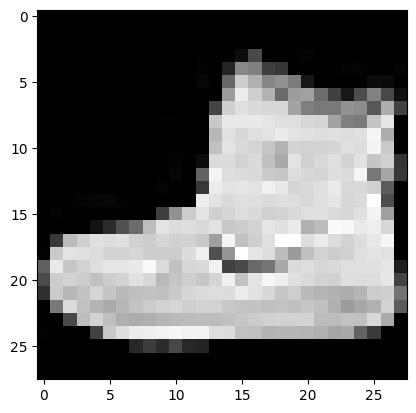

In [7]:
#샘플 이미지 확인
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

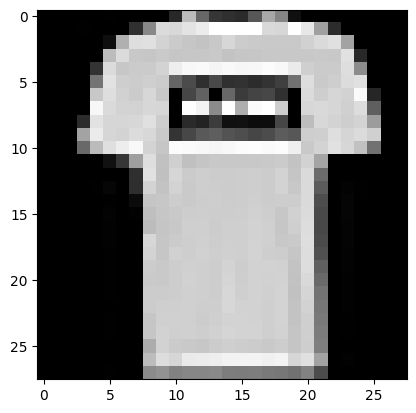

In [8]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[1], cmap='gray')
plt.show()

In [9]:
#타깃 내용과 의미 확인
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [10]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [11]:
print(class_names[y_train_all[0]])

앵클부츠


In [12]:
#타깃 분포 확인
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [13]:
#훈련 세트와 검증 세트 고르게 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [14]:
np.bincount(y_train)
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [15]:
#입력 데이터 정규화
x_train = x_train / 255
x_val = x_val / 255

In [16]:
#훈련 세트와 검증 세트 차원 변경
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [17]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [18]:
#타깃을 원-핫 인코딩으로 변환
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [19]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [20]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [21]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [22]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

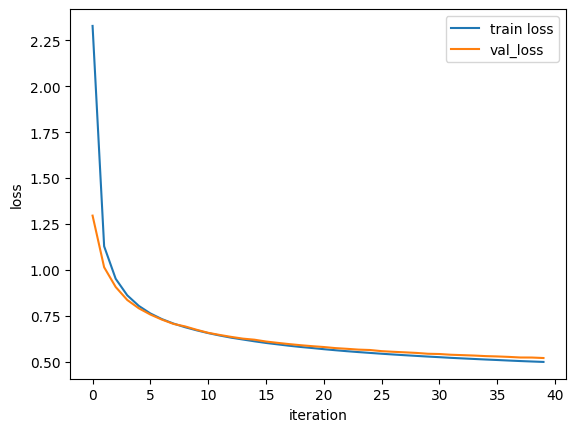

In [23]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train loss', 'val_loss'])
plt.show()

In [24]:
fc.score(x_val, y_val_encoded)

0.81475

7-2 텐서플로와 케라스를 사용하여 신경망 생성

In [29]:
#모델 생성
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [30]:
#은닉층과 출력층 모델에 추가
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [31]:
#최적화 알고리즘과 손실 함수 지정
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
#모델 훈련
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 5s 3ms/step - loss: 1.3834 - accuracy: 0.6343 - val_loss: 0.9536 - val_accuracy: 0.7254
Epoch 2/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.8361 - accuracy: 0.7377 - val_loss: 0.7467 - val_accuracy: 0.7542
Epoch 3/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7101 - accuracy: 0.7589 - val_loss: 0.6641 - val_accuracy: 0.7732
Epoch 4/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6486 - accuracy: 0.7755 - val_loss: 0.6148 - val_accuracy: 0.7881
Epoch 5/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6076 - accuracy: 0.7885 - val_loss: 0.5801 - val_accuracy: 0.7992
Epoch 6/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5779 - accuracy: 0.8005 - val_loss: 0.5528 - val_accuracy: 0.8066
Epoch 7/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5549 - accuracy: 0.8087 - val_loss: 0.5358 - val_accuracy:

In [33]:
#손실과 정확도 그래프 그리기
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


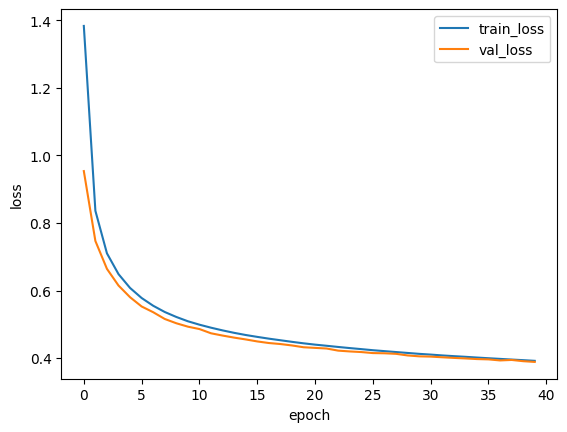

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

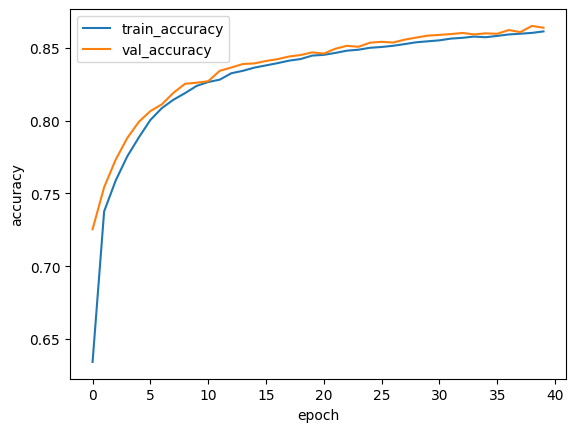

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [36]:
#검증 세트 정확도 계산
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8638333082199097
